In [ ]:
import torchvision
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [12, 10]

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())


# for i in range(1,17):
#     plt.subplot(4,4,i)
#     plt.imshow(mnist_train.train_data[i,:,:], cmap=plt.get_cmap('gray_r'))

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.11MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 58.1kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.36MB/s]


### Ejercicio 1: Clasificación de dígitos con MLP

- a) Primero, vamos a adaptar el perceptrón multicapa (MLP) implementado en la **práctica 1**, para que pueda clasificar imágenes de 28 x 28 en 10 categorías diferentes. Para ello, deberemos realizar algunos cambios:

  * Antes de procesar la imagen, deberemos reformatearla para que pase de ser una imagen de 28 x 28, a un vector de 784 componetes. Para ello, utilziaremos el método `view` de los tensores de Pytorch.

  * Utilizaremos un perceptrón con 15 neuronas en las capas intermedias.

  * La última capa deberá tener 10 neuronas (en lugar de 3 como tenia el perceptrón multicapa que utilizamos para hacer clasificación de especies de Iris).

  * Deberemos cambiar la función de pérdida. En este caso, utilizaremos Entropía Cruzada (`torch.nn.CrossEntropyLoss`)

- b) Entrenar el MLP:
  * Deberán construir un `Dataloader`'s a partir de los respectivos `Dataset`'s de arriba, y elegir un `batch_size` apropiado, así como un optimizador con un `learning_rate` apropiado.
  * Graficar la función de pérdida a lo largo del entrenamiento.
  * Guardar el modelo con `torch.save`.
  * Usar GPU (si Colab se los permite)
- c) Una vez entrenado, cargar el modelo con `torch.load_state_dict` a partir del archivo guardado (a menos que ya lo tengan en memoria) y:
  * Calcular las **métricas de clasificación** usuales dentro del dataset de test, para lo cual `sklearn.metrics.classification_report` puede ser útil.
  * Graficar la **matriz de confusión** para el mismo dataset.

In [ ]:
import torch
torch.cuda.is_available()
from torch import nn
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

class PerceptronMulticapa (nn.Module):

  def __init__ (self, n_entrada, n_oculta, n_salida, f_act = 'relu', semilla = None):
    super(PerceptronMulticapa, self).__init__()
    if semilla != None:
      torch.manual_seed(semilla)
      self.semilla = semilla
    self.n_entrada = n_entrada
    self.n_oculta = n_oculta
    self.n_salida = n_salida
    if f_act == 'relu':
      self.f_act = nn.ReLU()
    elif f_act == 'sigmoid':
      self.f_act = nn.Sigmoid()
    self.fc1 = torch.nn.Linear(n_entrada, n_oculta, dtype = torch.float32)
    self.fc2 = torch.nn.Linear(n_oculta, n_salida, dtype = torch.float32)

  def __str__ (self):
    return f"MLP con {self.n_entrada} entradas, {self.n_oculta} ocultas y {self.n_salida} salidas. Funcion de activación {self.f_act}."

  def correr (self, x_entrada):
    if len(x_entrada.shape) == 1:
      x_entrada = x_entrada.unsqueeze(0)
    if x_entrada.shape[1] != self.n_entrada:
      raise ValueError(f"Dimensión incorrecta: se esperaban {self.n_entrada} entradas por dato.")
    y1 = self.fc1(x_entrada)
    z1 = self.f_act(y1)
    y2 = self.fc2(z1)
    z2 = self.f_act(y2)
    return z2

  def entrenar (self, cargador: DataLoader, epocas = 100, f_p = None, optimizador = None,
                graficar_perdida = True, device = torch.device('cpu')) -> list:
    '''
    Puesta a punto para empezar el entrenamiento, instanciando todo aquello que haga falta.
    Deja al modelo entrenado con los parametros establecidos.
    Devuelve una lista con la perdida en cada epoca.
    '''
    if optimizador == None:
      optimizador = torch.optim.SGD(self.parameters(), lr = 1e-3, weight_decay = 0.0)
      print('Se usara optimizador estocastico de gradiente descendiente (SGD) con lr = 1e-3 y weight_decay = 0.')
    if f_p == None:
      f_p = nn.MSELoss(reduction = 'mean')
      print('Se usara funcion de perdida error cuadratico medio (MSE) con reduccion por promedio.')
    self.to(device)
    perdida = []
    for t in range(epocas):
      for i in cargador:
        x_entrada, salida_esperada = i
        x, y = i
        x_entrada = x_entrada.view(-1, 28*28) # esto es lo que corrige el tamaño (ver **)
        x_entrada = x_entrada.to(device)
        salida_esperada = salida_esperada.to(device)
        aux = self.iteracion_entrenamiento(x_entrada, salida_esperada, optimizador, f_p)
      perdida.append(aux)
    print(y[0])                                               #####################################################################################
    plt.figure(figsize = (8, 6))                              #####################################################################################
    plt.imshow(x[0,0,:,:], cmap = plt.get_cmap('gray_r'))     #####################################################################################
    plt.show()                                                #####################################################################################
    if graficar_perdida:
      plt.plot(range(1, epocas + 1), perdida)
      plt.title('Perdida vs Epoca')
      plt.xlabel('Epoca')
      plt.ylabel('Perdida')
      plt.show()
    return perdida

  def iteracion_entrenamiento (self, x_entrada, salida_esperada, optimizador, f_p):
    salida = self.correr(x_entrada)
    perdida = f_p(salida, salida_esperada)
    perdida.backward()
    optimizador.step()
    optimizador.zero_grad()
    return perdida.item()

  def evaluar (self, cargador, device = torch.device('cpu')):
    self.eval()
    self.to(device)
    todas_predicciones = []
    todas_verdaderas = []

    with torch.no_grad():
      for x_entrada, salida_esperada in cargador:
        x_entrada = x_entrada.view(-1, 28*28).to(device)
        salida_esperada = salida_esperada.to(device)

        salida = self.correr(x_entrada)
        predicciones = torch.argmax(salida, dim = 1)  # selecciona la clase con mayor probabilidad
                                                      # prediccion final del modelo, por muestra
        todas_predicciones.extend(predicciones.cpu().numpy())
        todas_verdaderas.extend(salida_esperada.cpu().numpy())

    print("Reporte de clasificación:\n")
    print(classification_report(todas_verdaderas, todas_predicciones, digits = 4))

    matriz_conf = confusion_matrix(todas_verdaderas, todas_predicciones)
    plt.figure(figsize = (8, 6))
    sns.heatmap(matriz_conf, annot=True, fmt = 'd', cmap = 'Blues',
                xticklabels = [str(i) for i in range(10)],
                yticklabels = [str(i) for i in range(10)])
    plt.xlabel('Etiqueta predicha')
    plt.ylabel('Etiqueta verdadera')
    plt.title('Matriz de Confusión - Dataset de Prueba')
    plt.show()

Usando GPU
tensor(4)


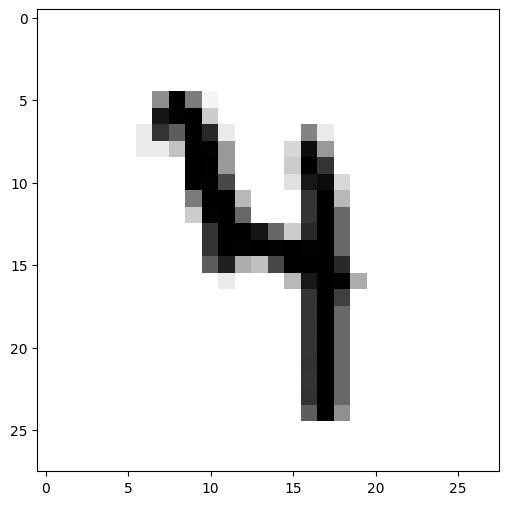

In [ ]:
# las imagenes fueron cargadas como tensores mediante:

# mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
# mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

from torch.utils.data import DataLoader

neuronas_entrada = 28*28
semilla = 110
modelo = PerceptronMulticapa(neuronas_entrada, 15, 10, 'relu', semilla = semilla)
lr = 1e-1
wd = 0.0
f_p = nn.CrossEntropyLoss() # es mejor no definirla dentro de la funcion entrenamiento, para no instanciarla cada vez
optimizador = torch.optim.SGD(modelo.parameters(), lr = lr, weight_decay = wd) # idem
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
  print("Usando GPU")
else:
  print("Usando CPU")

tamaño_batch = 600

cargador_entrenamiento  = DataLoader(mnist_train, batch_size = tamaño_batch, shuffle = True)

# **
# esto me deja batches de tamaño (tamaño_batch, 1, 28, 28)
# pero yo necesito convertir las matrices en vectores para ingresarlas al mlp
# entonces el tamaño nuevo debe ser (tamaño_batch, 28*28)

epocas = 1
perdida = modelo.entrenar(cargador_entrenamiento, epocas = epocas, f_p = f_p, optimizador = optimizador, device = device, graficar_perdida = False)

tensor([7])


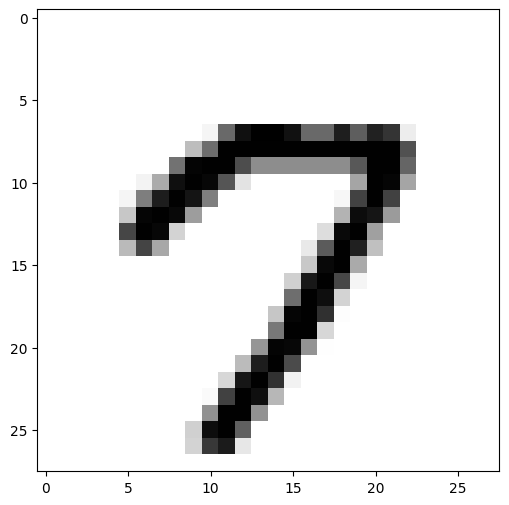

In [ ]:
tamaño_batch = 1

cargador_entrenamiento  = DataLoader(mnist_train, batch_size = tamaño_batch, shuffle = True)
x_entrada, salida_esperada = next(iter(cargador_entrenamiento))
print(salida_esperada)
plt.figure(figsize = (8, 6))
plt.imshow(x_entrada[0,0,:,:], cmap = plt.get_cmap('gray_r'))
plt.show()

Usando GPU


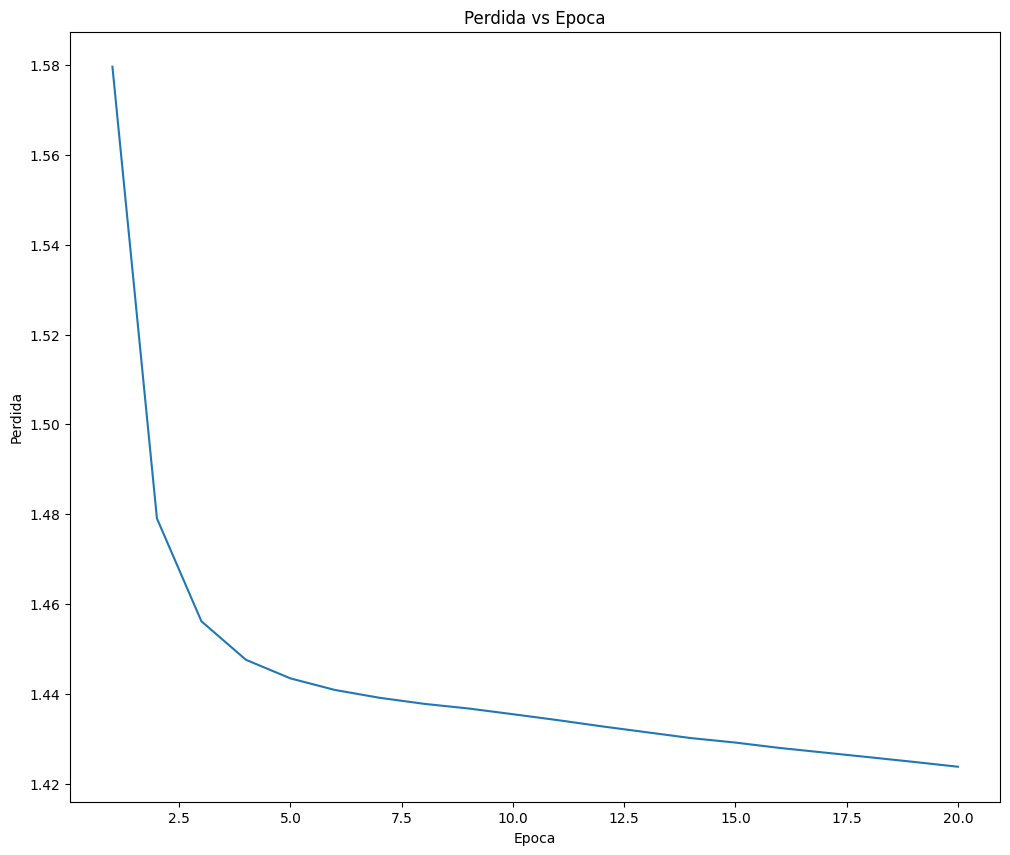

In [ ]:
# las imagenes fueron cargadas como tensores mediante:

# mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
# mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

from torch.utils.data import DataLoader

neuronas_entrada = 28*28
semilla = 17
modelo = PerceptronMulticapa(neuronas_entrada, 15, 10, 'relu', semilla = semilla)
lr = 1e-1
wd = 0.0
f_p = nn.CrossEntropyLoss() # es mejor no definirla dentro de la funcion entrenamiento, para no instanciarla cada vez
optimizador = torch.optim.SGD(modelo.parameters(), lr = lr, weight_decay = wd) # idem
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
  print("Usando GPU")
else:
  print("Usando CPU")

tamaño_batch = 600

cargador_entrenamiento  = DataLoader(mnist_train, batch_size = tamaño_batch, shuffle = False)

# **
# esto me deja batches de tamaño (tamaño_batch, 1, 28, 28)
# pero yo necesito convertir las matrices en vectores para ingresarlas al mlp
# entonces el tamaño nuevo debe ser (tamaño_batch, 28*28)

epocas = 20
perdida = modelo.entrenar(cargador_entrenamiento, epocas = epocas, f_p = f_p, optimizador = optimizador, device = device)

Usando GPU


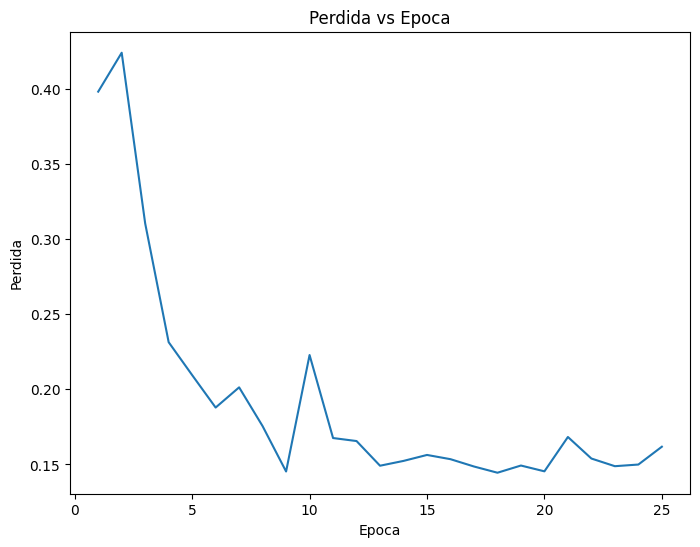

In [ ]:
# habiendo cargado el modelo otra vez.
# podria seguir entrenandolo?

lr = 1e-1 # le bajo el learning rate porque al final ya estaba oscilando mucho
wd = 0.0
f_p = nn.CrossEntropyLoss()
optimizador = torch.optim.SGD(modelo.parameters(), lr = lr, weight_decay = wd)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
  print("Usando GPU")
else:
  print("Usando CPU")

tamaño_batch = 6000

cargador_entrenamiento  = DataLoader(mnist_train, batch_size = tamaño_batch, shuffle = True)

epocas = 5
perdida2 = modelo.entrenar(cargador_entrenamiento, epocas = epocas, f_p = f_p, optimizador = optimizador, device = device,
                           graficar_perdida = False)
perdida = perdida + perdida2

plt.figure(figsize = (8, 6))
plt.plot(range(1, len(perdida) + 1), perdida)
plt.title('Perdida vs Epoca')
plt.xlabel('Epoca')
plt.ylabel('Perdida')
plt.show()

In [ ]:
# asi guardo el modelo en almacenamiento

nombre = 'lr_decrecientes'
ruta_guardado = '/content/modelos/' + nombre + '.pth'
torch.save(modelo.state_dict(), ruta_guardado)

In [ ]:
# para cargarlo, hace falta hacerlo sobre otro modelo de la misma
# clase y arquitectura. Por lo que hay que inicializar uno.

perdida = perdida[:10]
modelo_cargado = PerceptronMulticapa(neuronas_entrada, 15, 10, 'relu') # nuevo, igual que antes
modelo_cargado.load_state_dict(torch.load(ruta_guardado)) # sobreescribiendo el modelo anterior sobre el nuevo
modelo_cargado.train()

PerceptronMulticapa(
  (f_act): ReLU()
  (fc1): Linear(in_features=784, out_features=15, bias=True)
  (fc2): Linear(in_features=15, out_features=10, bias=True)
)

In [ ]:
# habiendo cargado el modelo otra vez.
# podria seguir entrenandolo?

lr = 1e-6 # le bajo el learning rate porque al final ya estaba oscilando mucho
wd = 0.0
f_p = nn.CrossEntropyLoss()
optimizador = torch.optim.SGD(modelo_cargado.parameters(), lr = lr, weight_decay = wd)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
  print("Usando GPU")
else:
  print("Usando CPU")

tamaño_batch = 6000

cargador_entrenamiento  = DataLoader(mnist_train, batch_size = tamaño_batch, shuffle = True)

epocas = 5
perdida2 = modelo_cargado.entrenar(cargador_entrenamiento, epocas = epocas, f_p = f_p, optimizador = optimizador, device = device,
                           graficar_perdida = False)
perdida = perdida + perdida2

Usando GPU


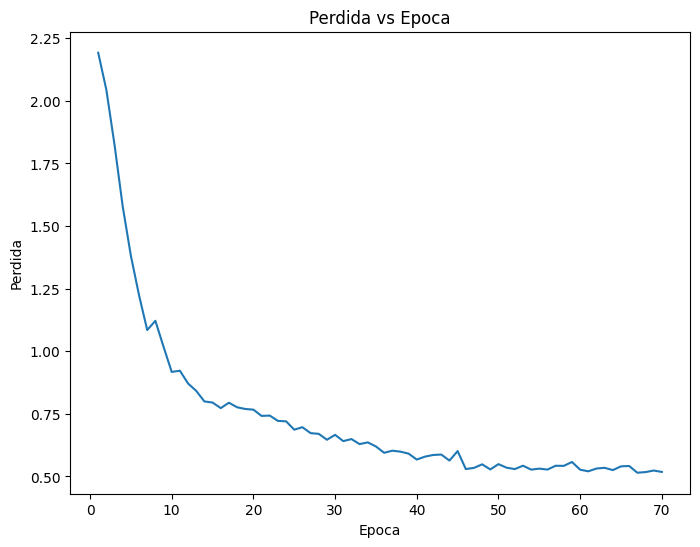

In [ ]:
plt.figure(figsize = (8, 6))
plt.plot(range(1, len(perdida) + 1), perdida)
plt.title('Perdida vs Epoca')
plt.xlabel('Epoca')
plt.ylabel('Perdida')
plt.show()

In [ ]:
# asi guardo el modelo en almacenamiento

nombre = 'lr_decrecientes_fin'
ruta_guardado = '/content/modelos/' + nombre + '.pth'
torch.save(modelo_cargado.state_dict(), ruta_guardado)

In [ ]:
# para cargarlo, hace falta hacerlo sobre otro modelo de la misma
# clase y arquitectura. Por lo que hay que inicializar uno.

perdida = perdida[:10]
modelo = PerceptronMulticapa(neuronas_entrada, 15, 10, 'relu') # nuevo, igual que antes
modelo.load_state_dict(torch.load(ruta_guardado)) # sobreescribiendo el modelo anterior sobre el nuevo
modelo.train()

PerceptronMulticapa(
  (f_act): ReLU()
  (fc1): Linear(in_features=784, out_features=15, bias=True)
  (fc2): Linear(in_features=15, out_features=10, bias=True)
)

Reporte de clasificación:

              precision    recall  f1-score   support

           0     0.9622    0.9867    0.9743       980
           1     0.9798    0.9806    0.9802      1135
           2     0.9504    0.9477    0.9491      1032
           3     0.9339    0.9376    0.9358      1010
           4     0.9522    0.9532    0.9527       982
           5     0.9500    0.9372    0.9436       892
           6     0.9515    0.9624    0.9569       958
           7     0.9682    0.9475    0.9577      1028
           8     0.9254    0.9302    0.9278       974
           9     0.9429    0.9336    0.9382      1009

    accuracy                         0.9521     10000
   macro avg     0.9517    0.9517    0.9516     10000
weighted avg     0.9521    0.9521    0.9521     10000



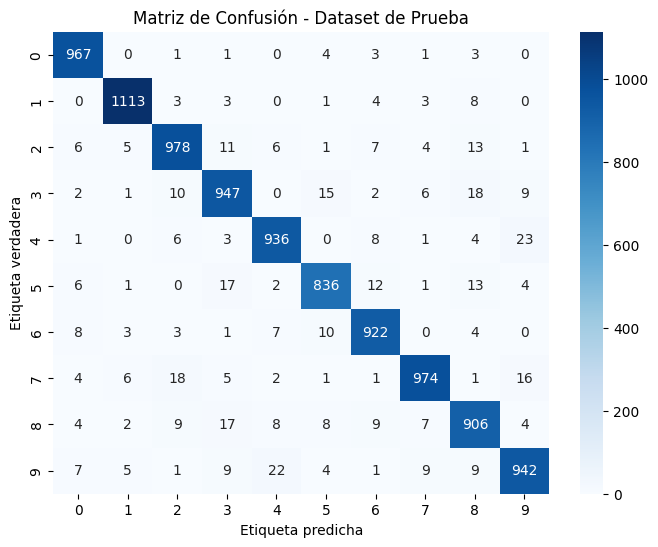

In [ ]:
batch_size = 1
cargador_prueba  = DataLoader(mnist_test, batch_size = tamaño_batch, shuffle = False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

modelo.evaluar(cargador_prueba, device = device)

### Ejercicio 2: red neuronal convolucional

a) Ahora definiremos un modelo `NetCNN` que implemente una red neuronal convolucional con un "cabezal" tipo MLP. El modelo tendrá la siguiente estructura:
* Capa convolucional (6 feature maps de salida) + ReLU
* Max pooling 2 x 2
* Capa convolucional (16 feature maps de salida) + ReLU
* Max pooling 2 x 2
* Capa totalmente conectada ($n$ neuronas de entrada y 120 neuronas de salida) + ReLU
* Capa totalmente conectada (84 neuronas de salida) + ReLU
* Capa de salida (10 neuronas de salida)

Realizar el cálculo del tamaño de la entrada y salida en cada capa convolucional en función de los parámetros de cada capa (tamaño del kernel, padding, stride, etc) para garantizar que los tensores que fluyen por la red sean del tamaño adecuado. Indicar el tamaño de los _feature maps_ a medida que fluyen por la red. Eso les permitirá encontrar el número $n$ de arriba para definir completamente la arquitectura de la red (tener en cuenta que los _feature maps_ se concatenan en un vector unidimensional antes de pasarlo por el cabezal MLP).

Recordar que, dados
* $F$: tamaño del filtro,
* $W$: tamaño del _feature map_ (o imagen) de entrada,
* $P$: padding,
* $S$: stride,

el tamaño de la salida de una capa convolucional es $O = \frac{(W - F + 2P)}{S} + 1$.


b) Entrenar el MLP:
  * Deberán construir un `Dataloader`'s a partir de los respectivos `Dataset`'s de arriba, y elegir un `batch_size` apropiado, así como un optimizador con un `learning_rate` apropiado.
  * Graficar la función de pérdida a lo largo del entrenamiento.
  * Guardar el modelo con `torch.save`.
  * Usar GPU (si Colab se los permite)

c) Una vez entrenado, cargar el modelo con `torch.load_state_dict` a partir del archivo guardado (a menos que ya lo tengan en memoria) y:
  * Calcular las **métricas de clasificación** usuales dentro del dataset de test, para lo cual `sklearn.metrics.classification_report` puede ser útil.
  * Graficar la **matriz de confusión** para el mismo dataset.


In [ ]:
# Entrada   -->              Capa conv. 1             -->   Salida 1
# 1x28x28   -->   6 F=1x5x5 P=0 S=1 ReLu maxpl(2x2)   -->   6x12x12
#                      6x1x5x5 = 150 parametros

# Salida 1  -->              Capa conv. 2              -->   Salida 2
# 6x12x12   -->   16 F=6x5x5 P=0 S=1 ReLu maxpl(2x2)   -->   16x4x4
#                     16x6x5x5 = 2400 parametros

# Parte convolucional: 150 + 2400 = 2550 parametros

# Salida 2  -->    Aplanado    -->  Capa entrada MLP
#   16x4x4            -->           256

# Capa entrada MLP   -->  Capa oculta MLP 1
# 256 neuronas ReLu  -->  120 neuronas
# 30720 pesos + 120 sesgos = 30840 parametros

# Capa oculta MLP 1  -->  Capa oculta MLP 2
# 120 neuronas ReLu  -->  84 neuronas
# 10080 pesos + 84 sesgos = 10164 parametros

# Capa oculta MLP 2  -->  Capa de salida
# 84 neuronas ReLu   -->  10 neuronas
# 840 pesos + 10 sesgos = 850 parametros

# Parte MLP: 30840 + 10164 + 850 = 41854 parametros

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

class NetCNN(nn.Module):

  def __init__ (self, f1 = 5, s1 = 1, p1 = 0, f2 = 5, s2 = 1, p2 = 0, semilla = None):
    '''
    Hay parametros no manejables, pues, se corresponden a aquellos dados por consigna.
    Como ser el tipo y tamaño del pooling, la cantidad de features map antes y despues
    de cada capa convolucional, las neuronas de cada capa MLP, y las funciones de activacion.
    '''
    super(NetCNN, self).__init__()
    if semilla != None:
      torch.manual_seed(semilla)
      self.semilla = semilla
    self.fm0 = 1
    self.fm1 = 6
    self.fm2 = 16
    self.relu = nn.ReLU()
    self.conv1 = nn.Conv2d(self.fm0, self.fm1, f1, s1, p1)
    self.pool1 = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(self.fm1, self.fm2, f2, s2, p2)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(self.fm2 * 4 * 4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward (self, x):
    h = self.conv1(x)
    h = self.relu(h)
    h = self.pool1(h)
    h = self.conv2(h)
    h = self.relu(h)
    h = self.pool2(h)
    h = h.view(-1, self.fm2 * 4 * 4) # aca se aplanan todos los features maps sobre un solo vector
    h = self.fc1(h)
    h = self.relu(h)
    h = self.fc2(h)
    h = self.relu(h)
    y = self.fc3(h)
    return y # 10 elementos

  def entrenar (self, cargador, epocas = 100, f_p = None, optimizador = None,
                graficar_perdida = True, device = torch.device('cpu')) -> list:
    '''
    Puesta a punto para empezar el entrenamiento, instanciando todo aquello que haga falta.
    Deja al modelo entrenado con los parametros establecidos.
    Devuelve una lista con la perdida en cada epoca.
    '''
    if optimizador == None:
      optimizador = torch.optim.SGD(self.parameters(), lr = 1e-3, weight_decay = 0.0)
      print('Se usara optimizador estocastico de gradiente descendiente (SGD) con lr = 1e-3 y weight_decay = 0.0')
    if f_p == None:
      f_p = nn.MSELoss(reduction = 'mean')
      print('Se usara funcion de perdida error cuadratico medio (MSE) con reduccion por promedio.')
    self.train()
    self.to(device)
    perdida = []
    for t in range(epocas):
      for i in cargador:
        x_entrada, salida_esperada = i
        x_entrada = x_entrada.to(device)
        salida_esperada = salida_esperada.to(device)
        aux = self.iteracion_entrenamiento(x_entrada, salida_esperada, optimizador, f_p)
      perdida.append(aux)
    if graficar_perdida:
      plt.style.use('dark_background')
      plt.figure(figsize = (8, 6))
      plt.plot(range(1, epocas + 1), perdida)
      plt.title('Perdida vs Epoca')
      plt.xlabel('Epoca')
      plt.ylabel('Perdida')
      plt.show()
    return perdida

  def iteracion_entrenamiento (self, x_entrada, salida_esperada, optimizador, f_p):
    salida = self(x_entrada)
    perdida = f_p(salida, salida_esperada)
    optimizador.zero_grad()
    perdida.backward()
    optimizador.step()
    return perdida.item()

  def evaluar (self, cargador, device = torch.device('cpu')):
    self.eval()
    self.to(device)
    todas_predicciones = []
    todas_verdaderas = []

    with torch.no_grad():
      for x_entrada, salida_esperada in cargador:
        x_entrada = x_entrada.to(device)
        salida_esperada = salida_esperada.to(device)

        salida = self(x_entrada)
        predicciones = torch.argmax(salida, dim = 1)

        todas_predicciones.extend(predicciones.cpu().numpy())
        todas_verdaderas.extend(salida_esperada.cpu().numpy())

    print("Reporte de clasificación:\n")
    print(classification_report(todas_verdaderas, todas_predicciones, digits = 4))

    matriz_conf = confusion_matrix(todas_verdaderas, todas_predicciones)
    plt.style.use('dark_background')
    plt.figure(figsize = (8, 6))
    sns.heatmap(matriz_conf, annot=True, fmt = 'd', cmap = 'cividis',
                xticklabels = [str(i) for i in range(10)],
                yticklabels = [str(i) for i in range(10)])
    plt.xlabel('Etiqueta predicha')
    plt.ylabel('Etiqueta verdadera')
    plt.title('Matriz de Confusión - Dataset de Prueba')
    plt.show()

Usando GPU


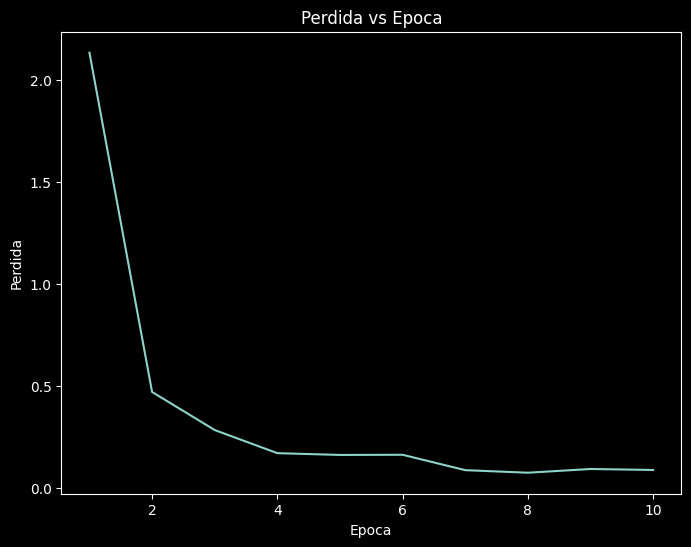

In [ ]:
# las imagenes fueron cargadas como tensores mediante:

# mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
# mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

f1 = 5
s1 = 1
p1 = 0
f2 = 5 # lo cambio como prueba de que pasa si reduzco el modelo
s2 = 1
p2 = 0
modelo = NetCNN(f1, s1, p1, f2, s2, p2)

lr = 1e-1
wd = 0.0
f_p = nn.CrossEntropyLoss()
optimizador = torch.optim.SGD(modelo.parameters(), lr = lr, weight_decay = wd)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
  print("Usando GPU")
else:
  print("Usando CPU")

tamaño_batch = 600

cargador_entrenamiento = DataLoader(mnist_train, batch_size = tamaño_batch, shuffle = True)

# **
# esto me deja batches de tamaño (tamaño_batch, 1, 28, 28)
# que es exactamente lo que el modelo espera recibir

epocas = 10
perdida = modelo.entrenar(cargador_entrenamiento, epocas = epocas, f_p = f_p, optimizador = optimizador, device = device)

In [ ]:
nombre = 'lr_decrecientes_conv3'
ruta_guardado = '/content/modelos/' + nombre + '.pth'
torch.save(modelo.state_dict(), ruta_guardado)

In [ ]:
# para cargar los 3, hay que cambiar el tamaño de los
# features maps ultimos en la funcion de CNN
modelo_cargado = NetCNN(f1, s1, p1, f2, s2, p2)
modelo_cargado.load_state_dict(torch.load(ruta_guardado))
modelo_cargado.train()

NetCNN(
  (relu): ReLU()
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(7, 7), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=144, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Usando GPU


Text(0, 0.5, 'Perdida')

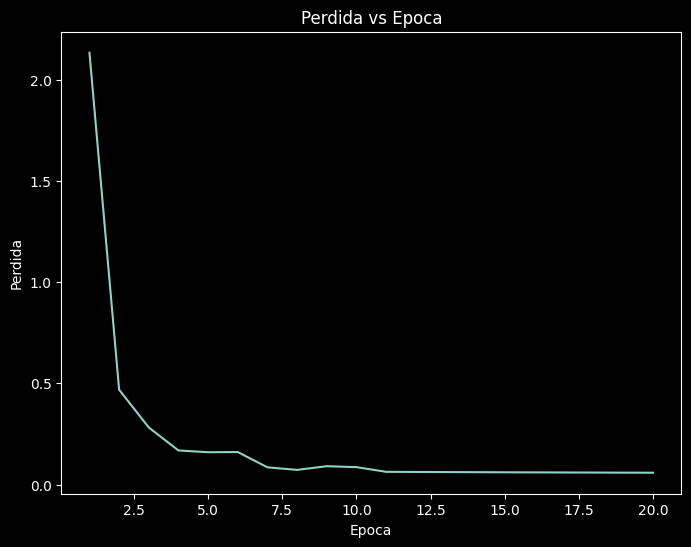

In [ ]:
# entreno otra vez

lr = 1e-1
wd = 0.0
f_p = nn.CrossEntropyLoss()
optimizador = torch.optim.SGD(modelo_cargado.parameters(), lr = lr, weight_decay = wd)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
  print("Usando GPU")
else:
  print("Usando CPU")

tamaño_batch = 6000

cargador_entrenamiento = DataLoader(mnist_train, batch_size = tamaño_batch, shuffle = False)

epocas = 10
perdida2 = modelo_cargado.entrenar(cargador_entrenamiento, epocas = epocas, f_p = f_p, optimizador = optimizador, device = device, graficar_perdida = False)

perdida = perdida + perdida2
plt.style.use('dark_background')
plt.figure(figsize = (8, 6))
plt.plot(range(1, len(perdida) + 1), perdida)
plt.title('Perdida vs Epoca')
plt.xlabel('Epoca')
plt.ylabel('Perdida')

In [ ]:
nombre = 'lr_decrecientes_conv3_fin'
ruta_guardado = '/content/modelos/' + nombre + '.pth'
torch.save(modelo_cargado.state_dict(), ruta_guardado)

In [ ]:
modelo_cargado = NetCNN(f1, s1, p1, f2, s2, p2)
modelo_cargado.load_state_dict(torch.load(ruta_guardado))
modelo_cargado.train()

NetCNN(
  (relu): ReLU()
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(7, 7), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=144, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Reporte de clasificación:

              precision    recall  f1-score   support

           0     0.9798    0.9898    0.9848       980
           1     0.9877    0.9885    0.9881      1135
           2     0.9788    0.9845    0.9816      1032
           3     0.9724    0.9772    0.9748      1010
           4     0.9837    0.9817    0.9827       982
           5     0.9754    0.9765    0.9759       892
           6     0.9874    0.9802    0.9838       958
           7     0.9804    0.9718    0.9761      1028
           8     0.9796    0.9836    0.9816       974
           9     0.9740    0.9653    0.9696      1009

    accuracy                         0.9800     10000
   macro avg     0.9799    0.9799    0.9799     10000
weighted avg     0.9800    0.9800    0.9800     10000



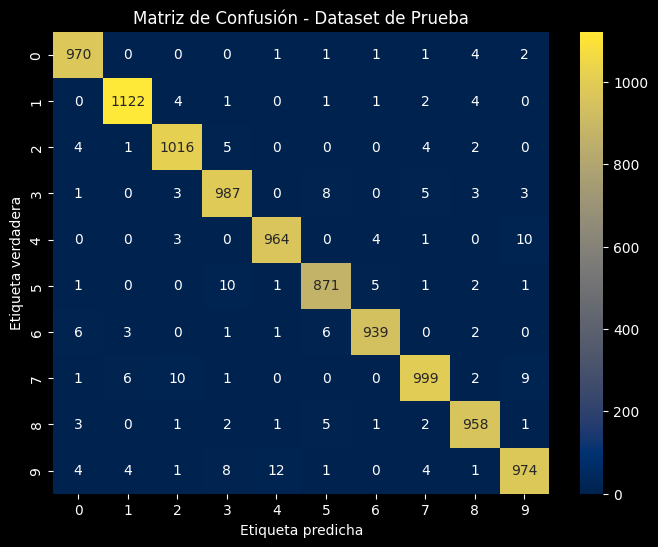

In [ ]:
batch_size = 1
cargador_prueba = DataLoader(mnist_test, batch_size = tamaño_batch, shuffle = False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

modelo_cargado.evaluar(cargador_prueba, device = device)

# Ejercicio 3

a) Estimar la memoria necesaria para hacer un pasaje `forward` y `backward` por las dos redes de arriba, dado un `batch_size`. Para `NetCNN`, estudiar separadamente el bloque convolucional y el bloque MLP. Notar qué elementos requieren la mayor parte de la memoria en cada caso: ¿son los pesos y gradientes? ¿o las "activaciones", es decir, los valores de la función en cada nodo?

b) Supongamos que no modificamos el bloque convolucional (incluyendo los _pooling_) y queremos pasar como entrada una imagen más grande. ¿Cómo debemos modificar la arquitectura de la red? ¿Qué ocurre con lo que calculamos en a)?


In [ ]:
# cada numero de tipo float32 es de 4 bytes

#######################################################################################
# MLP

# es de 784 -> 15 -> 10
# 784x15 + 15x10 pesos = 11910 pesos
# 15 + 10 = sesgos = 25 sesgos
# 11935 parametros
# 11935 parametros x 4 bytes/parametro = 47640 bytes
# esa es la memoria necesaria para ejecutar un forward o un backward

# para las activaciones, siendo B el tamaño de batch:
# B x (784 + 15 + 10) = Bx809   -->   B x 809 activaciones x 4 bytes = 3236 bytes/batch

#######################################################################################
# NetCNN

# parte CNN

# capa 1 : 6x1x5x5 = 150 parametros
# capa 2 : 16x6x5x5 = 2400 parametros
# total : 150 + 2400 = 2550 parametros   -->   2550 parametros x 4 bytes/parametro = 10200 bytes
# esa es la memoria necesaria para ejecutar un forward o un backward

# activaciones por batch
# capa 1 : 6x24x24 = 3456 act/batch   -->   3456 x 4 bytes = 13824 bytes/batch
# pooling capa 1 : 6x12x12 = 864 act/batch   -->   864 * 4 bytes = 3456 bytes/batch
# capa 2 : 6x8x8 = 384 act/batch   -->   384 x 4 bytes = 1536 bytes/batch
# pooling capa 2 : 16x4x4 = 256 act/batch   -->   256 x 4 bytes = 1024 bytes/batch
# total = 13824 + 3456 + 1536 + 1024 = 19840 bytes/batch

# parte MLP

# entrada --> oculta 1 :    256 x 120 = 30720 pesos
#                                     + 120 sesgos
#                                     = 30840 parametros
# oculta 1 --> oculta 2 :   120 x 84  = 10080 pesos
#                                     + 84 sesgos
#                                     = 10164 parametros
# oculta 2 --> salida :     84 x 10   = 840 pesos
#                                     + 10 pesos
#                                     = 850 parametros
# total : 30840 + 10164 + 850 = 41854 parametros   -->   41854 x 4 bytes = 167416 bytes
# esa es la memoria necesaria para ejecutar un forward o un backward

# activaciones por batch
# 256 + 120 + 84 + 10 = 470 activaciones/batch   -->   470 x 4 bytes = 1880 bytes/batch

# total CNN + MLP
# 10200 bytes + 167416 bytes = 177616 bytes
# para forward o backward
# 5.7% p/CNN   -   94.3% p/MLP

# 19840 + 1880 bytes/batch p/activaciones = 21720 bytes/batch p/activaciones
# 91.3% p/CNN   -   8.7% p/MLP

# en total, para una iteracion completa por batch:
# CNN : 10200x2 + 19840 = 40240 bytes/batch
# MLP : 167416x2 + 1880 = 336712 bytes/batch
# total :               = 376952 bytes/batch
# 10.7% p/CNN   -   89.3% p/MLP

In [ ]:
# Si se ingresa una imagen mas grande, la red convolusional la operará sin mas, pero cuando se llegue al aplanado de las imagenes
# y features map en un unico vector para ingresarse en el MLP, hará falta reescalar la capa de entrada para admitir las nuevas
# dimensiones del mismo.

# se modificaran las activaciones en el bloque CNN, y el costo de for/backward y activaciones en la parte MLP debido al cambio de
# dimensiones del vector de entrada.